# High Order Taylor Maps I

(original by Dario Izzo - extended by Ekin Ozturk)

Building upon the notebook [here](https://darioizzo.github.io/audi/notebooks/example12.html), we show the use of `desolver` for numerically integrating the system of differential equations $\dot{\mathbf y} = \mathbf f(\mathbf y)$:

$$
\begin{array}{l}
\dot r = v_r \\
\dot v_r = - \frac 1{r^2} + r v_\theta^2\\
\dot \theta = v_\theta \\
\dot v_\theta = -2 \frac{v_\theta v_r}{r}
\end{array}
$$

which describe, in non dimensional units, the Keplerian motion of a mass point object around some primary body. 
We show how we can build a high order Taylor map (HOTM, indicated with $\mathcal M$) representing the final state of the system at the time $T$ as a function of the initial conditions. 

In other words, we build a polinomial representation of the relation $\mathbf y(T) = \mathbf f(\mathbf y(0), T)$. Writing the initial conditions as $\mathbf y(0) = \overline {\mathbf y}(0) + \mathbf {dy}$, our HOTM will be written as:

$$
\mathbf y(T) = \mathcal M(\mathbf {dy})
$$

and will be valid in a neighbourhood of $\overline {\mathbf y}(0)$.

## Importing Stuff

In [1]:
%matplotlib inline
from matplotlib import pyplot as plt

import os
import numpy as np

os.environ['DES_BACKEND'] = 'numpy'
import desolver as de
import desolver.backend as D
from desolver.backend import gdual_double as gdual

PyAudi backend is available.
Using numpy backend


In [2]:
T = 1e-3

@de.rhs_prettifier(equ_repr="[vr, -1/r**2 + r*vt**2, vt, -2*vt*vr/r]", md_repr=r"""$$
\begin{array}{l}
\dot r = v_r \\
\dot v_r = - \frac 1{r^2} + r v_\theta^2\\
\dot \theta = v_\theta \\
\dot v_\theta = -2 \frac{v_\theta v_r}{r}
\end{array}
$$""")
def eom_kep_polar(t,y,**kwargs):
    return D.array([y[1], - 1 / y[0] / y[0] + y[0] * y[3]*y[3], y[3], -2*y[3]*y[1]/y[0] - T])

eom_kep_polar

$$
\begin{array}{l}
\dot r = v_r \\
\dot v_r = - \frac 1{r^2} + r v_\theta^2\\
\dot \theta = v_\theta \\
\dot v_\theta = -2 \frac{v_\theta v_r}{r}
\end{array}
$$

In [3]:
# The initial conditions
ic = [1.,0.1,0.,1.]

## We perform the numerical integration using floats (the standard way)

In [4]:
D.set_float_fmt('float64')
float_integration = de.OdeSystem(eom_kep_polar, y0=ic, dense_output=False, t=(0, 5.), dt=0.01, rtol=1e-12, atol=1e-12, constants=dict())

float_integration.set_method("RK45")
float_integration.integrate(eta=True)

Text(0, 0.5, 'y')

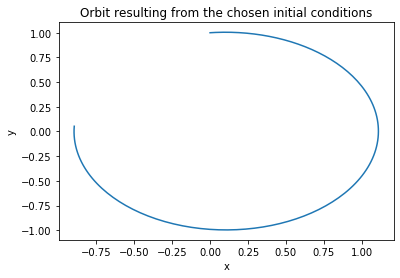

In [5]:
# Here we transform from polar to cartesian coordinates
# to then plot
y = float_integration.y
cx = [it[0]*np.sin(it[2]) for it in y.astype(np.float64)]
cy = [it[0]*np.cos(it[2]) for it in y.astype(np.float64)]
plt.plot(cx,cy)
plt.title("Orbit resulting from the chosen initial conditions")
plt.xlabel("x")
plt.ylabel("y")

## We perform the numerical integration using gduals (to get a HOTM)

In [6]:
# Order of the Taylor Map. If we have 4 variables the number of terms in the Taylor expansion in 329  at order 7
order = 5
# We now define the initial conditions as gdual (not float)
ic_g = [gdual(ic[0], "r", order), gdual(ic[1], "vr", order), gdual(ic[2], "t", order), gdual(ic[3], "vt", order)]

In [7]:
import time
start_time = time.time()
D.set_float_fmt('gdual_double')
gdual_integration = de.OdeSystem(eom_kep_polar, y0=ic_g, dense_output=False, t=(0, 5.), dt=0.01, rtol=1e-12, atol=1e-12, constants=dict())

gdual_integration.set_method("RK45")
gdual_integration.integrate(eta=True)
print("--- %s seconds ---" % (time.time() - start_time))


--- 3.7148001194000244 seconds ---


In [8]:
# We extract the last point
yf = gdual_integration.y[-1]
# And unpack it into some convinient names
rf,vrf,tf,vtf = yf
# We compute the final cartesian components
xf = rf * D.sin(tf)
yf = rf * D.cos(tf)
# Note that you can get the latex representation of the gdual
print(xf._repr_latex_())
print("xf (latex):")
xf

\[ 9.62324{dt}^{3}{dvt}^{2}-287.941{dt}^{2}{dvt}^{3}-339.246{dr}{dt}^{2}{dvr}^{2}-1163.38{dr}^{2}{dt}^{2}{dvr}-55841{dr}^{3}{dvr}-14155.1{dvt}^{4}+173.989{dvt}^{2}+45397.4{dr}^{4}{dt}-2.51218e+06{dr}^{2}{dvt}^{3}-36.4141{dt}^{2}{dvr}{dvt}+2655.96{dr}^{3}+8351.27{dr}{dt}{dvt}^{2}+134833{dr}^{3}{dt}{dvt}-4.31954e+06{dr}^{3}{dvt}^{2}-2.94774e+06{dr}^{2}{dvr}{dvt}^{2}-13.1439{dt}{dvr}^{2}+101890{dr}^{2}{dt}{dvr}{dvt}+22840.3{dr}{dt}{dvr}^{2}{dvt}+2550.6{dr}{dvr}{dvt}+5780.38{dr}^{2}{dvt}+346.756{dvr}^{2}{dvt}+1330.3{dt}{dvr}^{3}{dvt}-20.4879{dt}{dvt}+0.631304{dt}^{3}{dvr}-1710.37{dr}^{2}{dvr}^{2}-0.110791{dt}^{4}{dvt}-337.535{dr}{dt}^{2}{dvt}+762.507{dt}{dvr}{dvt}^{2}-64.2798{dr}{dt}{dvr}-25920.5{dvr}^{3}{dvt}^{2}+138.386{dvr}^{4}+0.633023{dvr}+83.5605{dt}{dvr}^{2}{dvt}+2892.65{dr}{dt}{dvr}{dvt}+72.8282{dvr}{dvt}-0.316512{dt}^{2}{dvr}+5.3273{dt}^{3}{dvr}{dvt}+46793.3{dr}{dt}{dvt}^{3}+141.812{dr}{dvr}+10.7133{dr}{dt}^{3}{dvr}-3.60855e+06{dr}^{3}{dvr}{dvt}-24.6985{dt}^{2}{dvr}^{3}-545726{dr}

Key type        : class obake::polynomials::d_packed_monomial<unsigned __int64,8,void>
Coefficient type: double
Tag             : struct obake::polynomials::tag
Rank            : 1
Symbol set      : {'dr', 'dt', 'dvr', 'dvt'}
Number of terms : 126
9.62324*dt**3*dvt**2-287.941*dt**2*dvt**3-339.246*dr*dt**2*dvr**2-1163.38*dr**2*dt**2*dvr-55841*dr**3*dvr-14155.1*dvt**4+173.989*dvt**2+45397.4*dr**4*dt-2.51218e+06*dr**2*dvt**3-36.4141*dt**2*dvr*dvt+2655.96*dr**3+8351.27*dr*dt*dvt**2+134833*dr**3*dt*dvt-4.31954e+06*dr**3*dvt**2-2.94774e+06*dr**2*dvr*dvt**2-13.1439*dt*dvr**2+101890*dr**2*dt*dvr*dvt+22840.3*dr*dt*dvr**2*dvt+2550.6*dr*dvr*dvt+5780.38*dr**2*dvt+346.756*dvr**2*dvt+1330.3*dt*dvr**3*dvt-20.4879*dt*dvt+0.631304*dt**3*dvr-1710.37*dr**2*dvr**2-0.110791*dt**4*dvt-337.535*dr*dt**2*dvt+762.507*dt*dvr*dvt**2-64.2798*dr*dt*dvr-25920.5*dvr**3*dvt**2+138.386*dvr**4+0.633023*dvr+83.5605*dt*dvr**2*dvt+2892.65*dr*dt*dvr*dvt+72.8282*dvr*dvt-0.316512*dt**2*dvr+5.3273*dt**3*dvr*dvt+46793.3*dr*dt*d

In [9]:
# We can extract the value of the polinomial when $\mathbf {dy} = 0$
print("Final x from the gdual integration", xf.constant_cf)
print("Final y from the gdual integration", yf.constant_cf)
# And check its indeed the result of the 'reference' trajectory (the lineariation point)
print("\nFinal x from the float integration", cx[-1])
print("Final y from the float integration", cy[-1])

Final x from the gdual integration -0.8953272292032805
Final y from the gdual integration 0.052709201662514145

Final x from the float integration -0.8953272292032807
Final y from the float integration 0.052709201662513354


## We visualize the HOTM

In [10]:
# Let us now visualize the Taylor map by creating a grid of perturbations on the initial conditions and
# evaluating the map for those values
Npoints = 10 # 10000 points
epsilon = 1e-3
grid = np.arange(-epsilon,epsilon,2*epsilon/Npoints)
nxf = [0] * len(grid)**4
nyf = [0] * len(grid)**4
i=0
import time
start_time = time.time()
for dr in grid:
    for dt in grid:
        for dvr in grid:
            for dvt in grid:
                nxf[i] = xf.evaluate({"dr":dr, "dt":dt, "dvr":dvr,"dvt":dvt})
                nyf[i] = yf.evaluate({"dr":dr, "dt":dt, "dvr":dvr,"dvt":dvt})
                i = i+1
print("--- %s seconds ---" % (time.time() - start_time))

--- 0.9997782707214355 seconds ---


Text(0.5, 1.0, 'Stretch')

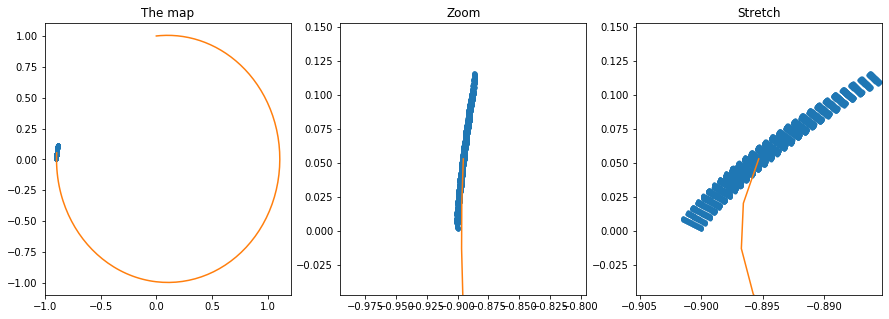

In [11]:
f, axarr = plt.subplots(1,3,figsize=(15,5))
# Normal plot of the final map
axarr[0].plot(nxf,nyf,'.')
axarr[0].plot(cx,cy)
axarr[0].set_title("The map")

# Zoomed plot of the final map (equal axis)
axarr[1].plot(nxf,nyf,'.')
axarr[1].plot(cx,cy)
axarr[1].set_xlim([cx[-1] - 0.1, cx[-1] + 0.1])
axarr[1].set_ylim([cy[-1] - 0.1, cy[-1] + 0.1])
axarr[1].set_title("Zoom")

# Zoomed plot of the final map (unequal axis)
axarr[2].plot(nxf,nyf,'.')
axarr[2].plot(cx,cy)
axarr[2].set_xlim([cx[-1] - 0.01, cx[-1] + 0.01])
axarr[2].set_ylim([cy[-1] - 0.1, cy[-1] + 0.1])
axarr[2].set_title("Stretch")
#axarr[1].set_xlim([cx[-1] - 0.1, cx[-1] + 0.1])
#axarr[1].set_ylim([cy[-1] - 0.1, cy[-1] + 0.1])

## How much faster is now to evaluate the Map rather than perform a new numerical integration?

In [12]:
# First we profile the method evaluate (note that you need to call the method 4 times to get the full state)

In [13]:
%timeit xf.evaluate({"dr":epsilon, "dt":epsilon, "dvr":epsilon,"dvt":epsilon})

50.3 µs ± 4.94 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
# Then we profile the Runge-Kutta 4 integrator

In [15]:
%%timeit
D.set_float_fmt('float64')
float_integration = de.OdeSystem(eom_kep_polar, y0=[it + epsilon for it in ic], dense_output=False, t=(0, 5.), dt=0.01, rtol=1e-12, atol=1e-12, constants=dict())

float_integration.set_method("RK45")
float_integration.integrate(eta=False)

75.1 ms ± 7.15 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


Text(0, 0.5, 'Error in estimating the final state (x)')

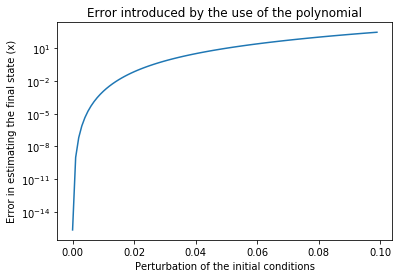

In [16]:
# It seems the speedup is 2-3 orders of magnitude, but did we loose precision?
# We plot the error in the final result as computed by the HOTM and by the Runge-Kutta
# as a function of the distance from the original initial conditions
out = []
pert = np.arange(0,0.1,1e-3)
for epsilon in pert:
    res_map_xf = xf.evaluate({"dr":epsilon, "dt":epsilon, "dvr":epsilon,"dvt":epsilon})
    res_int = de.OdeSystem(eom_kep_polar, y0=[it + epsilon for it in ic], dense_output=False, t=(0, 5.), dt=0.01, rtol=1e-12, atol=1e-12, constants=dict())
    res_int.set_method("RK45")
    res_int.integrate()
    res_int_x = [it.y[0]*np.sin(it.y[2]) for it in res_int]
    res_int_xf = res_int_x[-1]
    out.append(np.abs(res_map_xf - res_int_xf))
plt.semilogy(pert,out)
plt.title("Error introduced by the use of the polynomial")
plt.xlabel("Perturbation of the initial conditions")
plt.ylabel("Error in estimating the final state (x)")